Setup

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os
%matplotlib inline 

from os import chdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

## Introduction

## Data Import

In [18]:
# change the path to where you have downloaded the data set

#path = r"C:\Users\RAJI_\Documents\CS\Year 3\Data Mining (Maths)\Assignment2"
path = os.getcwd()
chdir(path)
# set the path to our current working directory
data = pd.read_csv('CreditCard_train.csv', header =1)

## Data Transformation and Exploration

In [19]:
# checking we have the correct data columns and glancing over the data
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,12000.500000,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,6928.347566,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,1.000000,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,6000.750000,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,12000.500000,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,18000.250000,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,24000.000000,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


Initially, taking an overview of out data: 

Education is represented as numerical values which each represents a different level of education. We will replace this feature with some dummy categories as the the numbers 1, 2, 3 which represent Grad, Univeristy and High Shool education respecitvly will bring new meaning to these categories due to its mathemticla properties. We can eliminate this by replacing them with binary dummy variables

In [20]:
grad = (data['EDUCATION'] == 1).astype('int')
uni = (data['EDUCATION'] == 2).astype('int')
hs = (data['EDUCATION'] == 3).astype('int') 
data.insert(loc=3, column='GRAD_SCHOOL', value=grad)
data.insert(loc=3, column='UNIVERSITY', value=uni)
data.insert(loc=3, column='HIGH_SCHOOL', value=hs)
data = data.drop(columns = 'EDUCATION')

Take a general overview at the dataset, from 24000 sets of data, the average age is about 36. The majority are either from graduate school or university.  Mostly our candidates are married or single.


Columms: ['LIMIT_BAL', 'SEX', 'HIGH_SCHOOL', 'UNIVERSITY', 'GRAD_SCHOOL', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Basic ['SEX', 'HIGH_SCHOOL', 'UNIVERSITY', 'GRAD_SCHOOL', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4']
Money ['LIMIT_BAL', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


/Users/hjd970707/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


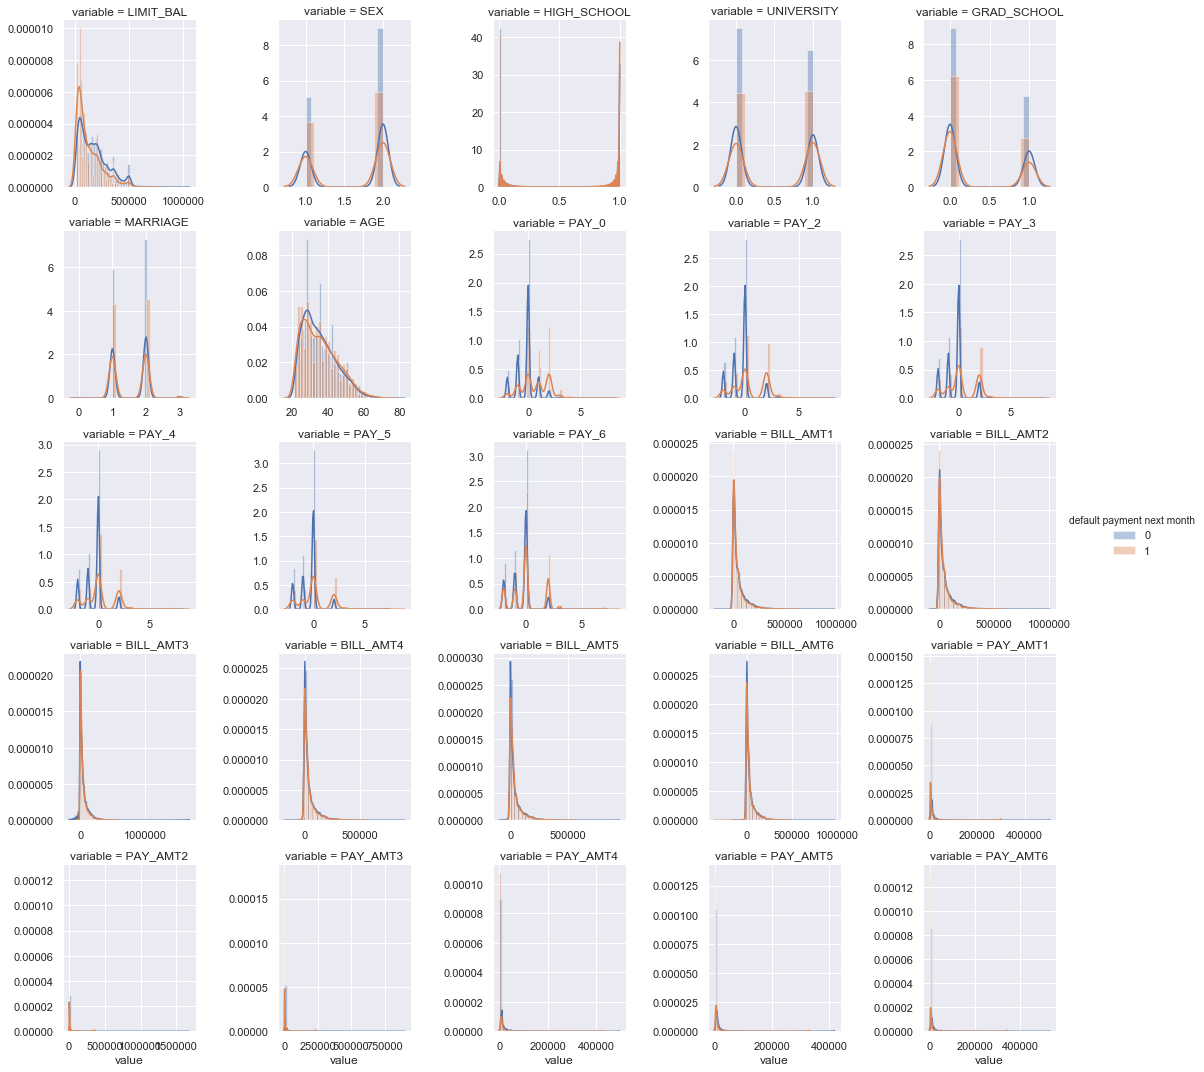

In [21]:
# Let's do a little data visualisation
cols = [ f for f in data.columns if data.dtypes[ f ] != "object" and f!= 'ID']
del cols[-1:]
basicData = cols[1:11]
moneyData = [x for x in cols if x not in basicData]
print('Columms:', cols)
print('Basic',basicData)
print('Money',moneyData)

#loggedData = data.drop(columns = cols[:11])
#print(list(loggedData))

# We plot some distibution plot
f = pd.melt(data, id_vars='default payment next month', value_vars= cols)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=5, sharex=False, sharey=False)
g = g.map( sns.distplot, "value", kde=True).add_legend()

We see that the values regarding amounts of money are heavily skewed to the left hand side. We can try and elimate this by transforming these features

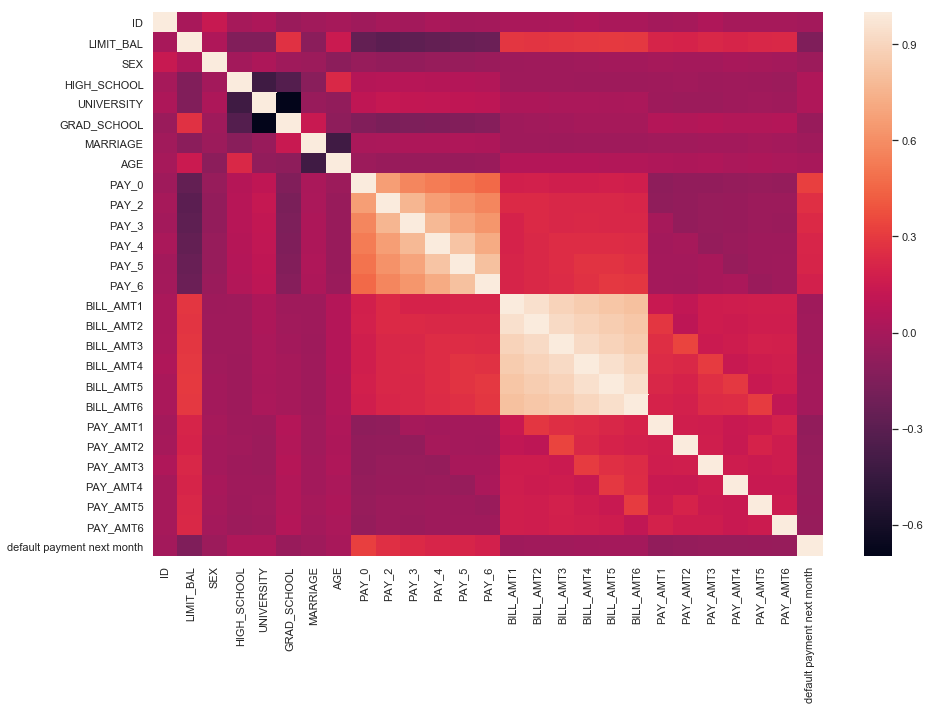

In [22]:
corr = data.corr()
plt.subplots(figsize=(15,10))
from seaborn import heatmap
ax = heatmap(corr)
plt.show()

['LIMIT_BAL', 'SEX', 'HIGH_SCHOOL', 'UNIVERSITY', 'GRAD_SCHOOL', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


/Users/hjd970707/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


['log_LIMIT_BAL', 'SEX', 'HIGH_SCHOOL', 'UNIVERSITY', 'GRAD_SCHOOL', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'log_PAY_AMT1', 'log_PAY_AMT2', 'log_PAY_AMT3', 'log_PAY_AMT4', 'log_PAY_AMT5', 'log_PAY_AMT6', 'log_BILL_AMT1', 'log_BILL_AMT2', 'log_BILL_AMT3', 'log_BILL_AMT4', 'log_BILL_AMT5', 'log_BILL_AMT6']


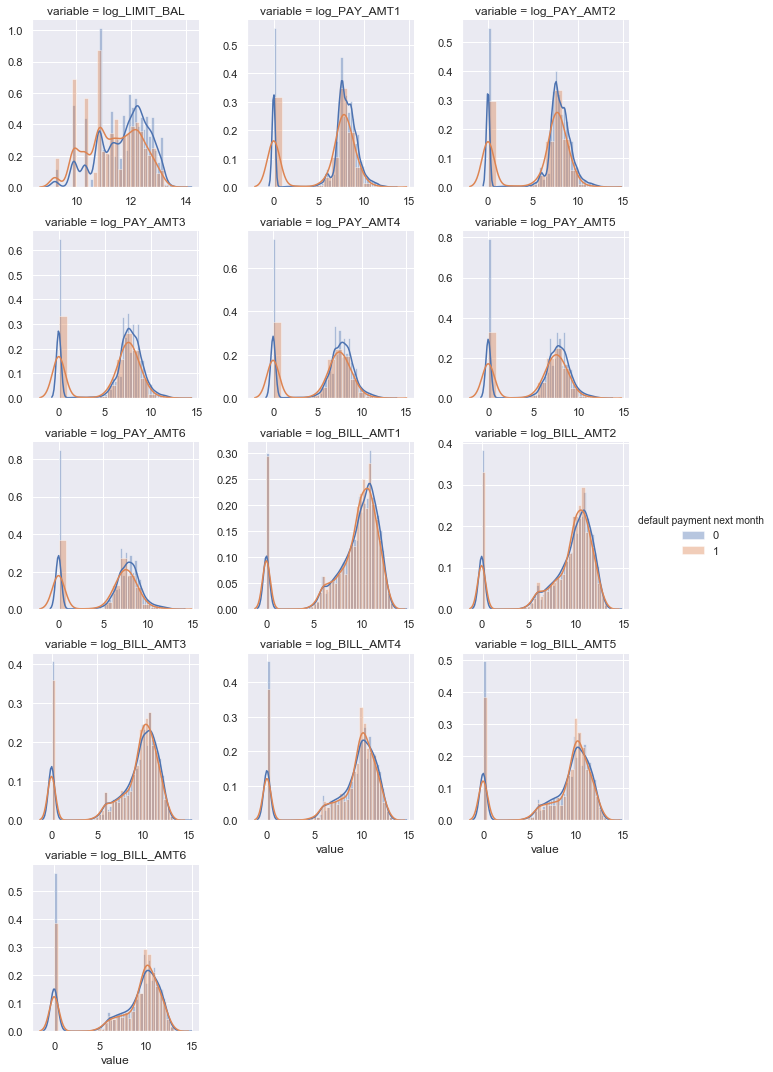

In [23]:
print(cols)
#qual_Enc = cols
#qual_Enc.remove("LIMIT_BAL")
#qual_Enc.remove("AGE")

logged = []
data["log_LIMIT_BAL"] = data["LIMIT_BAL"].apply( lambda x: np.log1p(x) if x>0 else 0)
logged.append("log_LIMIT_BAL")

for ii in range(1,7):
    #qual_Enc.remove("PAY_AMT" + str( ii ))
    data[ "log_PAY_AMT" + str( ii )]  = data["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    #qual_Enc.remove("BILL_AMT" + str( ii ))
    data[ "log_BILL_AMT" + str( ii )] = data["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( data, id_vars='default payment next month', value_vars=logged)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

logged[1:1] = basicData
#logged.insert(1, basicData)
print(logged)

['log_LIMIT_BAL', 'SEX', 'HIGH_SCHOOL', 'UNIVERSITY', 'GRAD_SCHOOL', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'log_PAY_AMT1', 'log_PAY_AMT2', 'log_PAY_AMT3', 'log_PAY_AMT4', 'log_PAY_AMT5', 'log_PAY_AMT6', 'log_BILL_AMT1', 'log_BILL_AMT2', 'log_BILL_AMT3', 'log_BILL_AMT4', 'log_BILL_AMT5', 'log_BILL_AMT6']


/Users/hjd970707/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


 1    21600
-1     2400
Name: 0, dtype: int64


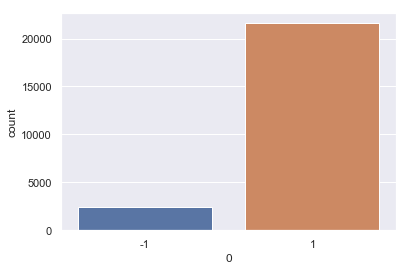

In [24]:
#logged.append('default payment next month')
print(logged)

rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
clf.fit(data[logged])
output_table = pd.DataFrame(clf.predict(data[logged]))
print(output_table[0].value_counts())
ax = sns.countplot(x=output_table[0],data=output_table)
plt.show()

['LIMIT_BAL', 'SEX', 'HIGH_SCHOOL', 'UNIVERSITY', 'GRAD_SCHOOL', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


/Users/hjd970707/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


 1    21600
-1     2400
Name: 0, dtype: int64


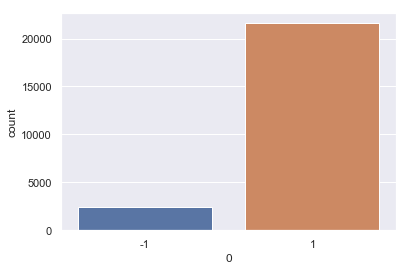

In [25]:
cols.append('default payment next month')
print(cols)

rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
clf.fit(data[cols])
output_table = pd.DataFrame(clf.predict(data[cols]))
print(output_table[0].value_counts())
ax = sns.countplot(x=output_table[0],data=output_table)
plt.show()

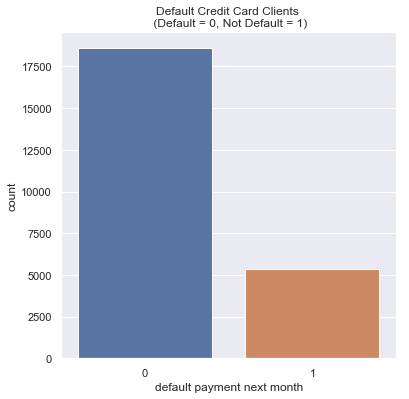

In [26]:
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients \n (Default = 0, Not Default = 1)')
ax = sns.countplot(x="default payment next month", data=data)

Spliting the dataset into several sectors. Looking at the repayment status records, we draw a count graph for each column:

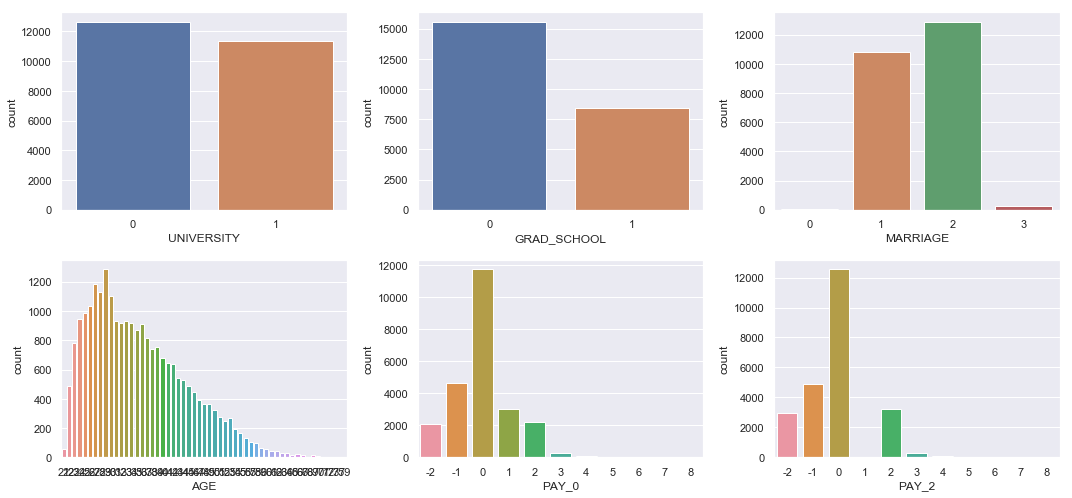

In [27]:
#Repayment Status
plt.figure(figsize = (15,10))
i = 0
for c in cols[3:9]:
    i= i+1
    plt.subplot(3,3,i)
    ax = sns.countplot(x=c, data=data)
    plt.tight_layout() 

From the countplots, we observe that there are two unknown variables for repayment status:-2 and 0. Technically we should consider these variables as "NA" (Not Applicable). We could either delete these observations or replace the undocumented variables with the most relevant value. However, considering the vast quantity, I think the best idea it to keep those observations as "NAs" and see how does it affect the predicted output.


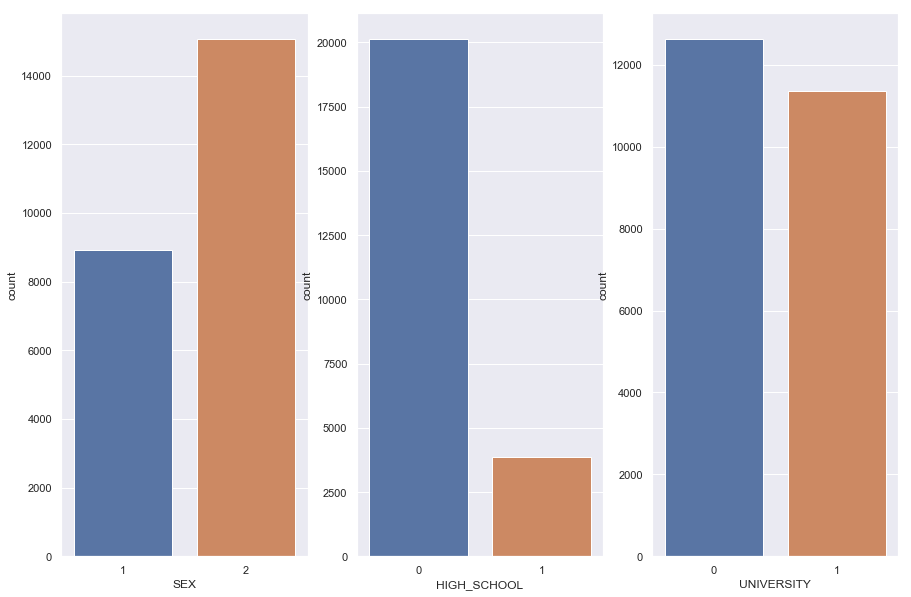

In [28]:
#Social Status(SEX, EDUCATION, MARRIAGE)

figs, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.ravel()

for counter in range(3):
    col = data.columns[2+counter]
    sns.set(style="darkgrid")
    sns.countplot(x=str(col), data=data,ax=axs[counter])
plt.show()


We summerise the sex, marriage and eduation as the social status sector. Again we notice that there are obervations with several undocumented values. For example, 0,5 and 6 for education. As I stated before, we could classify those as NA and  keep them as it is for now.

In [29]:
#check the inter-quartile range of the data 
print(data.AGE.quantile([0.25,0.5,0.75]))

0.25    28.0
0.50    34.0
0.75    41.0
Name: AGE, dtype: float64


One definition of outlier is any data point more than 1.5 inter-quartile range(IQR) below Q1 or above Q3. The IQR is 13, therefore outliers are points lying above 60.5 and below 8.5


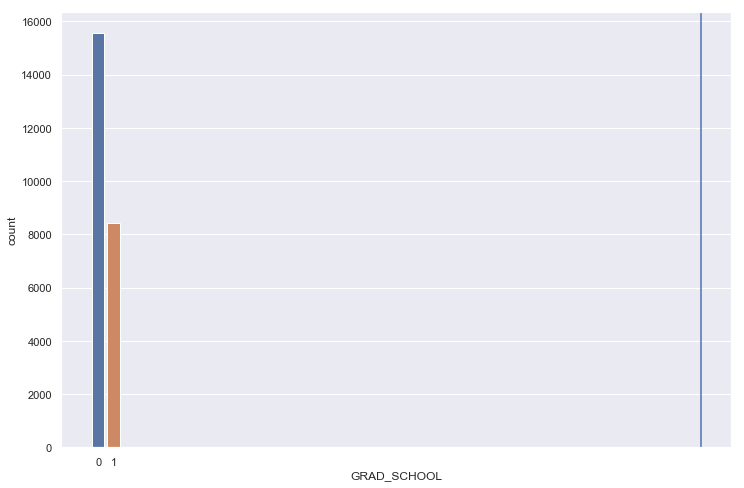

In [30]:
#Age 
plt.figure(figsize=(12,8))
col = data.columns[5]
sns.set(style="darkgrid")
ax=sns.countplot(x=str(col), data=data)
plt.axvline(x=39)
plt.show()

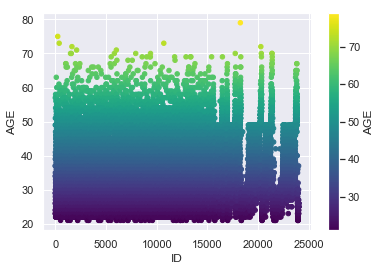

In [31]:
#Age Scatter
fig, ax = plt.subplots()
data.plot.scatter(x='ID', y='AGE',c='AGE', cmap='viridis',ax=ax)
plt.show()

From the scatter plot, the strange thing is that with index more than 15000, the structure of the data seems like to have some kind of periodic patterns. To make sure that data with index more than 15000 is valid, we have drawed another histogram to analyse the strcture of the data.

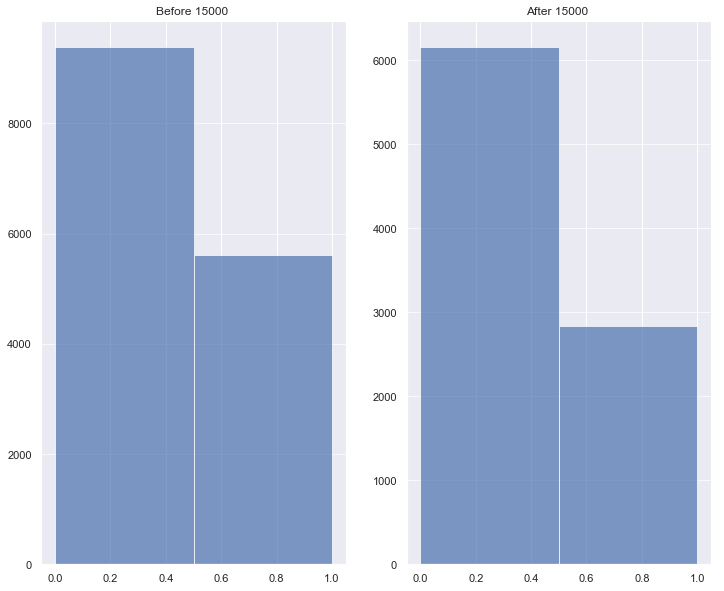

In [32]:
#comparing 2 groups
figs, axs = plt.subplots(1, 2, figsize=(12, 10))
#before 15000
col = data.columns[5]
distinct=len(data[col].unique())
axs[0].hist(data[col][:15000], bins=distinct,alpha=0.7)
axs[0].grid(axis='y',alpha=0.75)
axs[0].set_title("Before 15000 ")

#after 15000
col = data.columns[5]
distinct=len(data[col].unique())
axs[1].hist(data[col][15000:], bins=distinct,alpha=0.7)
axs[1].grid(axis='y',alpha=0.75)
axs[1].set_title("After 15000 ")

plt.show()

Text(0.5,1,'Before 15000 ')

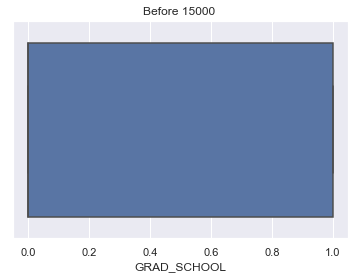

In [33]:
sns.boxplot(x=data[col][:15000]).set_title("Before 15000 ")


Text(0.5,1,'After 15000 ')

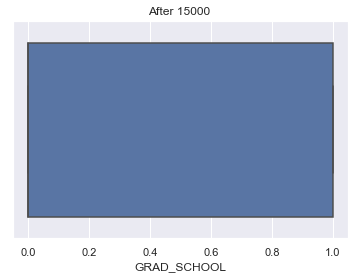

In [34]:
sns.boxplot(x=data[col][15000:]).set_title("After 15000 ")

Text(0.5,1,'Before 15000 ')

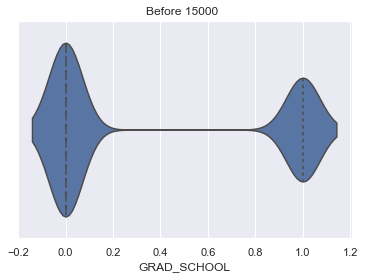

In [35]:
sns.violinplot(x=data[col][:15000],inner="quartile",data=data).set_title("Before 15000 ")

Text(0.5,1,'After 15000 ')

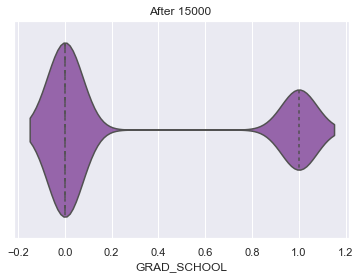

In [36]:
sns.violinplot(x=data[col][15000:],inner="quartile",data=data,color="#9b59b6").set_title("After 15000 ")

 Both parts of the data hava the same structure and density, therefore the second part of the data is valid 

In [37]:
#Amount of bill statement:
for c in range(1,7):
    string="BILL_AMT"+str(c)
    print(data[string].quantile([0.25,0.5,0.75]))

0.25     3631.5
0.50    22330.0
0.75    65779.5
Name: BILL_AMT1, dtype: float64
0.25     3098.50
0.50    21339.00
0.75    62761.25
Name: BILL_AMT2, dtype: float64
0.25     2773.5
0.50    20039.0
0.75    59298.0
Name: BILL_AMT3, dtype: float64
0.25     2340.0
0.50    18940.5
0.75    52188.5
Name: BILL_AMT4, dtype: float64
0.25     1740.0
0.50    18107.5
0.75    49746.5
Name: BILL_AMT5, dtype: float64
0.25     1234.75
0.50    17036.00
0.75    48796.25
Name: BILL_AMT6, dtype: float64


Again by making use of the definition of outlier:
 >Q3+1.5∗IQR or <Q1−1.5∗IQR


In the graphs belows, we add two imaginary lines indicting the lower bound and upeer bound for outliers

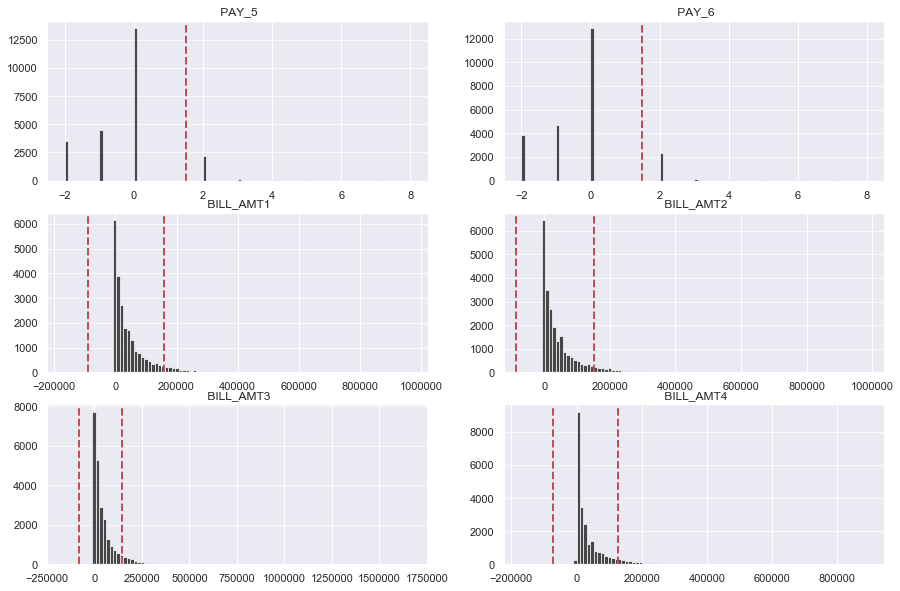

In [38]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[12 + counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    distinct=len(data[col].unique())
    axs[counter].hist(data[col], bins=100,color='black',alpha=0.7,rwidth=1.5)
    axs[counter].axvline(x=low, color='r', linestyle='dashed', linewidth=2)
    axs[counter].axvline(x=high, color='r', linestyle='dashed', linewidth=2)
    axs[counter].grid(axis='y',alpha=0.75)
    axs[counter].set_title(" "+col)
plt.show()

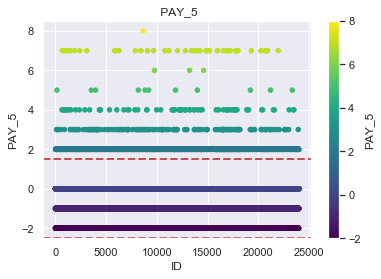

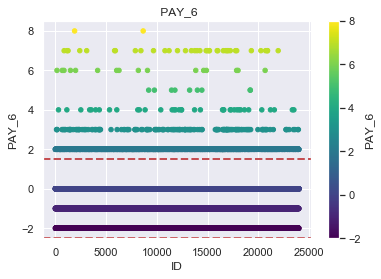

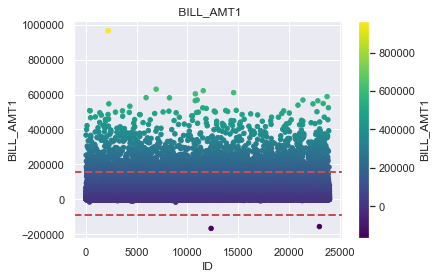

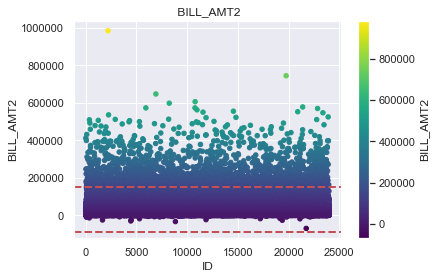

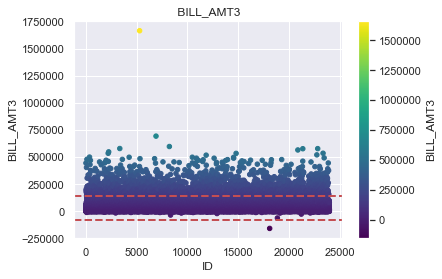

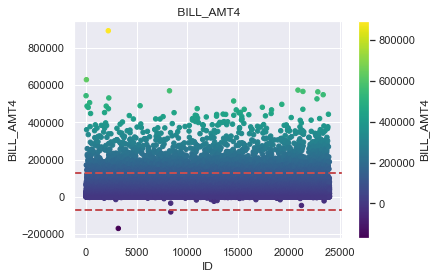

In [39]:
for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[12+counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=low, color='r', linestyle='dashed', linewidth=2)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

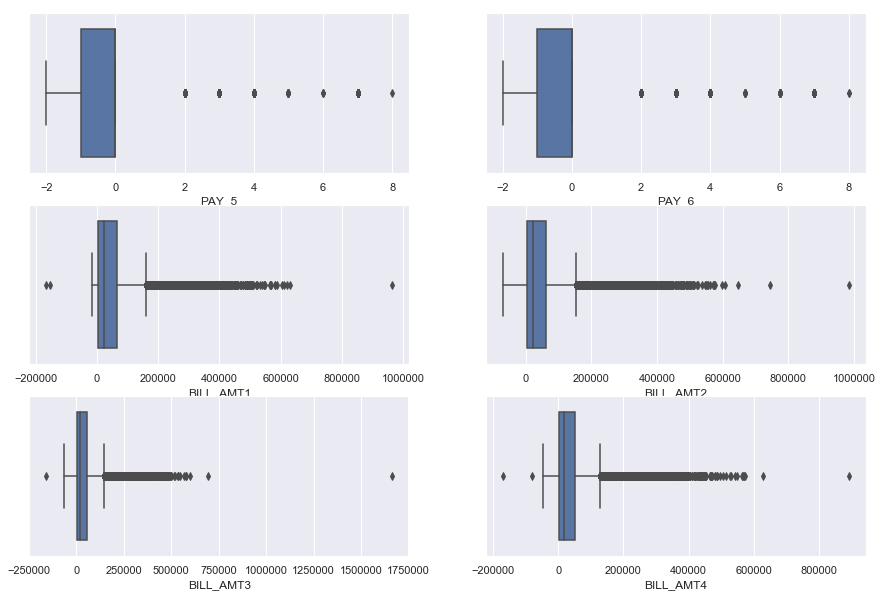

In [40]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[12+counter]
    sns.boxplot(x=data[col],ax=axs[counter])
plt.show()


It looks like our current definition of outlier has a very limited range. The first solution is to give a higher bound for outliers, for example we could define Q3*1.5 IQR +300000 as the higher bound for outliers. Secondly we could also do some data tranformtion to this data. I would suggest try taking the log of the data because of negative values or set the upper bound to Q3*1.5 IQR +300000. Let us see the effect:

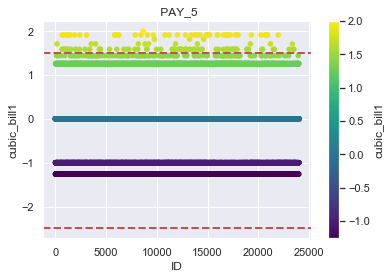

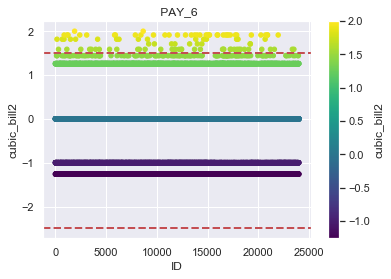

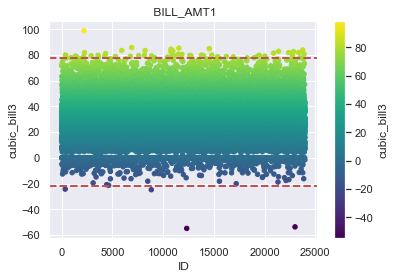

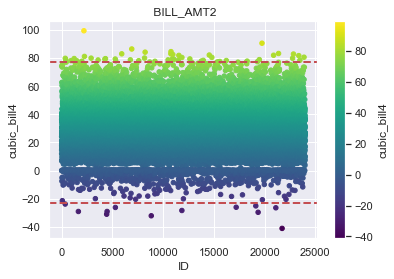

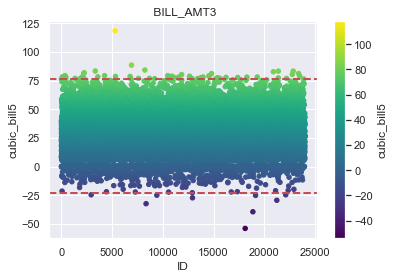

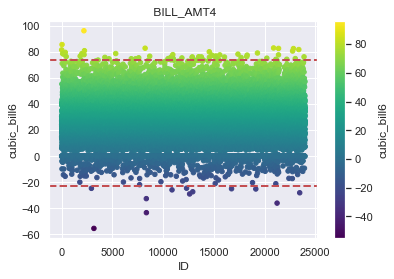

In [41]:
#log
for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[12+counter]
    data['cubic_bill'+str(counter+1)] = np.cbrt(data[col])

    l,h=data['cubic_bill'+str(counter+1)].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    data.plot.scatter(x='ID', y='cubic_bill'+str(counter+1),c='cubic_bill'+str(counter+1), cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=low, color='r', linestyle='dashed', linewidth=2)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

Remove the outliers and transfer the data back the original form

In [42]:

print(data.columns.values)


['ID' 'LIMIT_BAL' 'SEX' 'HIGH_SCHOOL' 'UNIVERSITY' 'GRAD_SCHOOL'
 'MARRIAGE' 'AGE' 'PAY_0' 'PAY_2' 'PAY_3' 'PAY_4' 'PAY_5' 'PAY_6'
 'BILL_AMT1' 'BILL_AMT2' 'BILL_AMT3' 'BILL_AMT4' 'BILL_AMT5' 'BILL_AMT6'
 'PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4' 'PAY_AMT5' 'PAY_AMT6'
 'default payment next month' 'log_LIMIT_BAL' 'log_PAY_AMT1'
 'log_PAY_AMT2' 'log_PAY_AMT3' 'log_PAY_AMT4' 'log_PAY_AMT5'
 'log_PAY_AMT6' 'log_BILL_AMT1' 'log_BILL_AMT2' 'log_BILL_AMT3'
 'log_BILL_AMT4' 'log_BILL_AMT5' 'log_BILL_AMT6' 'cubic_bill1'
 'cubic_bill2' 'cubic_bill3' 'cubic_bill4' 'cubic_bill5' 'cubic_bill6']


In [43]:
for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[12+counter]
    data['cubic_bill'+str(counter+1)] = np.cbrt(data[col])

    l,h=data['cubic_bill'+str(counter+1)].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    if
    data.plot.scatter(x='ID', y='cubic_bill'+str(counter+1),c='cubic_bill'+str(counter+1), cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=low, color='r', linestyle='dashed', linewidth=2)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

SyntaxError: invalid syntax (<ipython-input-43-bdf65cf0c5e9>, line 10)

In [ ]:
#Amount of previous payment
for c in range(1,7):
    string="PAY_AMT"+str(c)
    print(data[string].quantile([0.25,0.5,0.75]))

For this sector, we do not have any more negative values now and use the same method as before

In [ ]:
figs, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()
for counter in range(6):
    col = data.columns[18 + counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    distinct=len(data[col].unique())
    axs[counter].hist(data[col], bins=100,color='black',alpha=0.7,rwidth=1.5)
    axs[counter].axvline(x=low, color='r', linestyle='dashed', linewidth=2)
    axs[counter].axvline(x=high, color='r', linestyle='dashed', linewidth=2)
    axs[counter].grid(axis='y',alpha=0.75)
    axs[counter].set_title(" "+col)
plt.show()

Obviously we could discard our lower bound for outliers as all the data is positive

In [ ]:
for counter in range(6):
    fig, ax = plt.subplots()
    col = data.columns[18+counter]
    l,h=data[col].quantile([0.25,0.75])
    rang=1.5*(h-l)
    low=l-rang
    high=h+rang
    data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
    ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

plt.show()

Our current upper bound seems like it to low for this set of data

In [ ]:
#Limit Balance
col = data.columns[1]
l,h=data[col].quantile([0.25,0.75])
rang=1.5*(h-l)
low=l-rang
high=h+rang
distinct=len(data[col].unique())
plt.hist(data[col], bins=150,color='black',alpha=0.7,rwidth=1.5)
plt.axvline(x=high, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [ ]:
   print(data["LIMIT_BAL"].quantile([0,0.25,0.5,0.75,1]))

In [ ]:
fig, ax = plt.subplots()
col = data.columns[1]
l,h=data[col].quantile([0.25,0.75])
rang=1.5*(h-l)
low=l-rang
high=h+rang
data.plot.scatter(x='ID', y=col,c=col, cmap='viridis',ax=ax).set_title(" "+col)
ax.axhline(y=high, color='r', linestyle='dashed', linewidth=2)

In [ ]:
rng = np.random.RandomState(24000)
clf = IsolationForest(max_samples='auto',
                      random_state=rng,)
clf.fit(data)
output_table = pd.DataFrame(clf.predict(data))
print(output_table[0].value_counts())
ax = sns.countplot(x=output_table[0],data=output_table)
plt.show()

Methodology Overview

Model training/validation

Results

Final predictions on test set